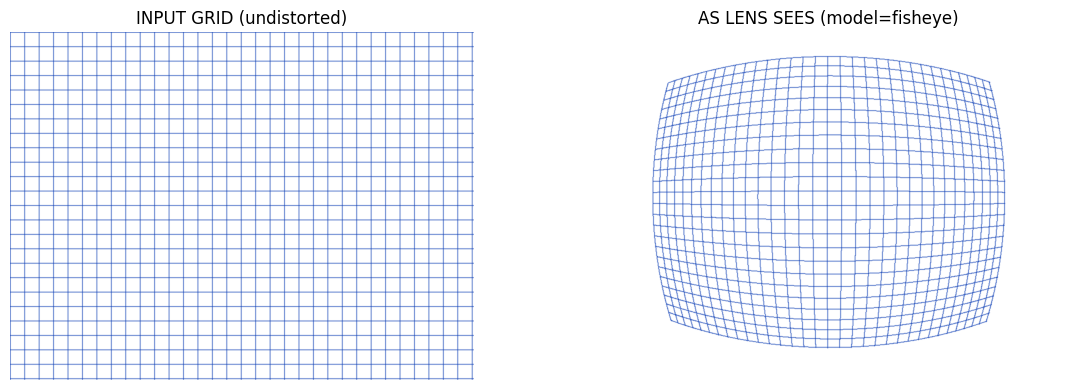

wrote: C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\test_set\distortion_from_npz.png


In [1]:
import numpy as np, cv2, math, matplotlib.pyplot as plt, pathlib

# ---- helper ----
def load_cal(cal_path):
    cal = np.load(cal_path, allow_pickle=True)
    return {
        "path": cal_path,
        "model": str(cal["model"]),
        "K": cal["K"].astype(np.float64),
        "D": cal["D"].astype(np.float64),
        "img_size": tuple(map(int, cal["img_size"])),  # (W,H)
    }

def scale_K(K, sx, sy):
    """이미지 크기를 (W,H)->(W',H')로 바꿀 때 K도 함께 스케일"""
    K2 = K.copy()
    K2[0,0] *= sx; K2[1,1] *= sy
    K2[0,2] *= sx; K2[1,2] *= sy
    K2[2,2] = 1.0
    return K2

def make_grid_lines(W, H, step_px):
    """수직/수평 격자 라인 포인트(undistorted pixel 좌표)를 리스트로 반환"""
    lines = []
    ys = np.arange(0, H, 1, dtype=np.float64)
    for x in np.arange(0, W, step_px, dtype=np.float64):
        xs = np.full_like(ys, x)
        lines.append(np.stack([xs, ys], axis=1))  # vertical
    xs = np.arange(0, W, 1, dtype=np.float64)
    for y in np.arange(0, H, step_px, dtype=np.float64):
        ys = np.full_like(xs, y)
        lines.append(np.stack([xs, ys], axis=1))  # horizontal
    return lines

def warp_lines_with_cal(lines, K, D, model):
    """
    undistorted pixel 좌표(lines) -> "렌즈가 만들어낼" distorted pixel 좌표
    원리: (u,v)->정규화(X,Y)로 역투영 후, cv2의 projectPoints로 왜곡+내부참조 적용
    """
    out = []
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]

    # 한 번에 처리
    pts = np.concatenate(lines, axis=0)  # (N,2) in pixels (undistorted)
    X = (pts[:,0] - cx) / fx
    Y = (pts[:,1] - cy) / fy
    obj = np.stack([X, Y, np.ones_like(X)], axis=1).reshape(-1,1,3).astype(np.float64)

    rvec = np.zeros((3,1), np.float64)
    tvec = np.zeros((3,1), np.float64)

    if model == "fisheye":
        imgPts, _ = cv2.fisheye.projectPoints(obj, rvec, tvec, K, D)
    else:  # pinhole
        imgPts, _ = cv2.projectPoints(obj, rvec, tvec, K, D)
    P = imgPts.reshape(-1,2)

    # 다시 라인 단위로 쪼개기
    o, s = [], 0
    for L in lines:
        n = len(L)
        o.append(P[s:s+n]); s += n
    return o

def draw_lines(W, H, lines, color=(210, 80, 0), thickness=1):
    """OpenCV로 라인 드로잉 (BGR)"""
    canvas = np.full((H, W, 3), 255, np.uint8)
    for L in lines:
        pts = np.round(L).astype(int)
        pts[:,0] = np.clip(pts[:,0], 0, W-1)
        pts[:,1] = np.clip(pts[:,1], 0, H-1)
        for i in range(len(pts)-1):
            cv2.line(canvas, tuple(pts[i]), tuple(pts[i+1]), color, thickness, cv2.LINE_AA)
    return canvas

# ---- run (single calib) ----
CAL_PATH = r"chess_try_0/calib_out/calib.npz"  # <- 네 파일 경로
C = load_cal(CAL_PATH)

# 표시용 해상도(너무 크면 보기 힘드니 원본 대비 축소)
W0,H0 = C["img_size"]
MAX_W = 900
scale = min(1.0, MAX_W / W0)
W, H = int(W0*scale), int(H0*scale)
K = scale_K(C["K"], scale, scale)
D = C["D"]
model = C["model"]

step = max(8, min(W,H)//24)  # 라인 간격 자동 선택(약 20~30줄)
grid_und = make_grid_lines(W, H, step)
grid_dst = warp_lines_with_cal(grid_und, K, D, model)

img_in  = draw_lines(W, H, grid_und, color=(180,60,10), thickness=1)
img_out = draw_lines(W, H, grid_dst, color=(180,60,10), thickness=1)

# 시각화
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.title("INPUT GRID (undistorted)"); plt.imshow(cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,2,2); plt.title(f"AS LENS SEES (model={model})"); plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.tight_layout()
plt.show()

# 저장
out_path = pathlib.Path("distortion_from_npz.png")
cv2.imwrite(str(out_path), np.hstack([img_in, img_out]))
print("wrote:", out_path.resolve())


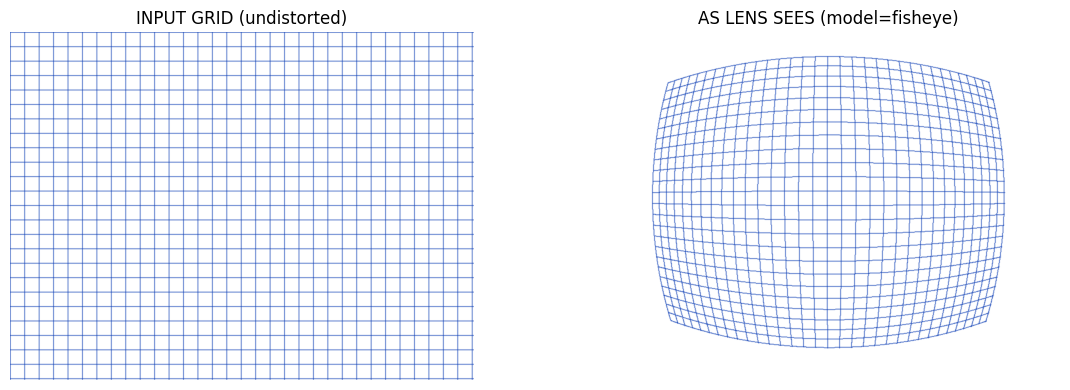

wrote: C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\test_set\distortion_from_npz.png


In [2]:
import numpy as np, cv2, math, matplotlib.pyplot as plt, pathlib

# ---- helper ----
def load_cal(cal_path):
    cal = np.load(cal_path, allow_pickle=True)
    return {
        "path": cal_path,
        "model": str(cal["model"]),
        "K": cal["K"].astype(np.float64),
        "D": cal["D"].astype(np.float64),
        "img_size": tuple(map(int, cal["img_size"])),  # (W,H)
    }

def scale_K(K, sx, sy):
    """이미지 크기를 (W,H)->(W',H')로 바꿀 때 K도 함께 스케일"""
    K2 = K.copy()
    K2[0,0] *= sx; K2[1,1] *= sy
    K2[0,2] *= sx; K2[1,2] *= sy
    K2[2,2] = 1.0
    return K2

def make_grid_lines(W, H, step_px):
    """수직/수평 격자 라인 포인트(undistorted pixel 좌표)를 리스트로 반환"""
    lines = []
    ys = np.arange(0, H, 1, dtype=np.float64)
    for x in np.arange(0, W, step_px, dtype=np.float64):
        xs = np.full_like(ys, x)
        lines.append(np.stack([xs, ys], axis=1))  # vertical
    xs = np.arange(0, W, 1, dtype=np.float64)
    for y in np.arange(0, H, step_px, dtype=np.float64):
        ys = np.full_like(xs, y)
        lines.append(np.stack([xs, ys], axis=1))  # horizontal
    return lines

def warp_lines_with_cal(lines, K, D, model):
    """
    undistorted pixel 좌표(lines) -> "렌즈가 만들어낼" distorted pixel 좌표
    원리: (u,v)->정규화(X,Y)로 역투영 후, cv2의 projectPoints로 왜곡+내부참조 적용
    """
    out = []
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]

    # 한 번에 처리
    pts = np.concatenate(lines, axis=0)  # (N,2) in pixels (undistorted)
    X = (pts[:,0] - cx) / fx
    Y = (pts[:,1] - cy) / fy
    obj = np.stack([X, Y, np.ones_like(X)], axis=1).reshape(-1,1,3).astype(np.float64)

    rvec = np.zeros((3,1), np.float64)
    tvec = np.zeros((3,1), np.float64)

    if model == "fisheye":
        imgPts, _ = cv2.fisheye.projectPoints(obj, rvec, tvec, K, D)
    else:  # pinhole
        imgPts, _ = cv2.projectPoints(obj, rvec, tvec, K, D)
    P = imgPts.reshape(-1,2)

    # 다시 라인 단위로 쪼개기
    o, s = [], 0
    for L in lines:
        n = len(L)
        o.append(P[s:s+n]); s += n
    return o

def draw_lines(W, H, lines, color=(210, 80, 0), thickness=1):
    """OpenCV로 라인 드로잉 (BGR)"""
    canvas = np.full((H, W, 3), 255, np.uint8)
    for L in lines:
        pts = np.round(L).astype(int)
        pts[:,0] = np.clip(pts[:,0], 0, W-1)
        pts[:,1] = np.clip(pts[:,1], 0, H-1)
        for i in range(len(pts)-1):
            cv2.line(canvas, tuple(pts[i]), tuple(pts[i+1]), color, thickness, cv2.LINE_AA)
    return canvas

# ---- run (single calib) ----
CAL_PATH = r"chess_try_1/calib_out/calib.npz"  # <- 네 파일 경로
C = load_cal(CAL_PATH)

# 표시용 해상도(너무 크면 보기 힘드니 원본 대비 축소)
W0,H0 = C["img_size"]
MAX_W = 900
scale = min(1.0, MAX_W / W0)
W, H = int(W0*scale), int(H0*scale)
K = scale_K(C["K"], scale, scale)
D = C["D"]
model = C["model"]

step = max(8, min(W,H)//24)  # 라인 간격 자동 선택(약 20~30줄)
grid_und = make_grid_lines(W, H, step)
grid_dst = warp_lines_with_cal(grid_und, K, D, model)

img_in  = draw_lines(W, H, grid_und, color=(180,60,10), thickness=1)
img_out = draw_lines(W, H, grid_dst, color=(180,60,10), thickness=1)

# 시각화
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.title("INPUT GRID (undistorted)"); plt.imshow(cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,2,2); plt.title(f"AS LENS SEES (model={model})"); plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.tight_layout()
plt.show()

# 저장
out_path = pathlib.Path("distortion_from_npz.png")
cv2.imwrite(str(out_path), np.hstack([img_in, img_out]))
print("wrote:", out_path.resolve())


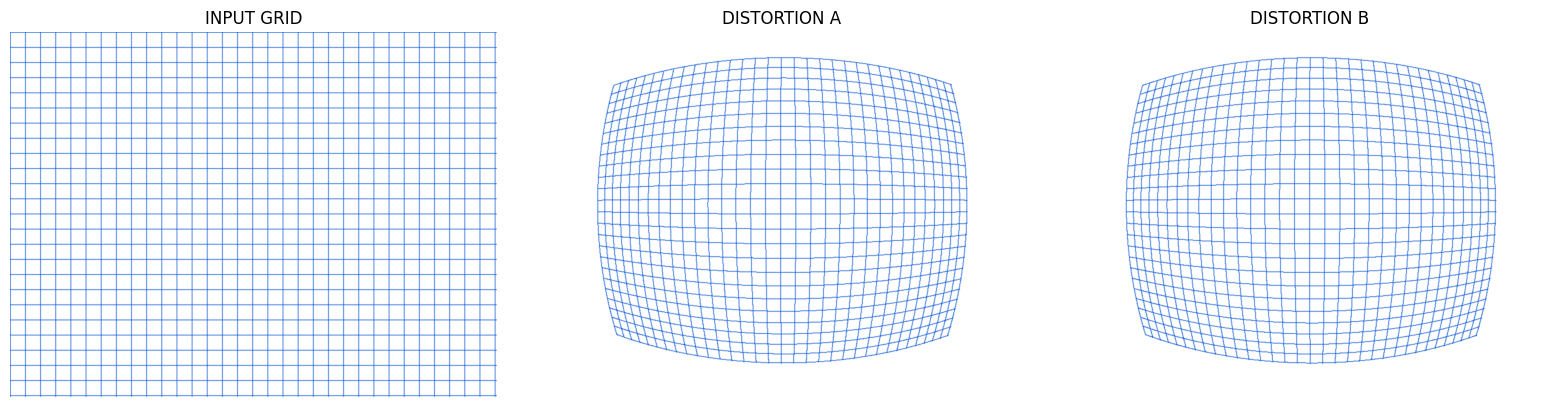

wrote: C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\test_set\distortion_compare_A_B.png


In [3]:
# 두 버전 비교
CAL_A = r"chess_try_0/calib_out/calib.npz"   # 추가 전
CAL_B = r"chess_try_1/calib_out/calib.npz"       # 추가 후

A = load_cal(CAL_A)
B = load_cal(CAL_B)

# 비교는 같은 표시 크기에서
W0,H0 = A["img_size"]
assert A["img_size"] == B["img_size"], "두 npz의 img_size가 다르면 보기 공정성이 떨어집니다."
MAX_W = 900
scale = min(1.0, MAX_W / W0)
W, H = int(W0*scale), int(H0*scale)

KA = scale_K(A["K"], scale, scale); DA = A["D"]; MA = A["model"]
KB = scale_K(B["K"], scale, scale); DB = B["D"]; MB = B["model"]

step = max(8, min(W,H)//24)
grid_und = make_grid_lines(W, H, step)
grid_a = warp_lines_with_cal(grid_und, KA, DA, MA)
grid_b = warp_lines_with_cal(grid_und, KB, DB, MB)

img_in  = draw_lines(W, H, grid_und)
img_a   = draw_lines(W, H, grid_a)
img_b   = draw_lines(W, H, grid_b)

fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1); plt.title("INPUT GRID"); plt.imshow(cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("DISTORTION A"); plt.imshow(cv2.cvtColor(img_a,  cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,3); plt.title("DISTORTION B"); plt.imshow(cv2.cvtColor(img_b,  cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.tight_layout(); plt.show()

out_path = pathlib.Path("distortion_compare_A_B.png")
cv2.imwrite(str(out_path), np.hstack([img_in, img_a, img_b]))
print("wrote:", out_path.resolve())
